In [ ]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import PIL.ImageOps
import requests
from PIL import Image

## Data Augmentation for Training data

In [ ]:
transform  = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor()
                                ])
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor()
                               ])

training_dataset = datasets.CIFAR10(root='./cifar10', train=True, 
                                  download=True, transform= transform_train)
validation_dataset = datasets.CIFAR10(root='./cifar10', train=False, 
                                  download=True, transform= transform) 

Files already downloaded and verified
Files already downloaded and verified


## Adjust model architecture

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
      self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
      self.fc1 = nn.Linear(4*4*32, 120)
      self.fc2 = nn.Linear(120, 84)
      self.output = nn.Linear(84, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*32)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.output(x)
      return x

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')

model = LeNet().to(device)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, 
                                              batch_size=100,
                                              shuffle=True)
   
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                              batch_size=100,
                                              shuffle=True)

# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

train_corrects_history = []
val_corrects_history = []

epochs = 15
for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)
        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 100 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_data in validation_loader:
                val_inputs = val_data[0].to(device)
                val_labels = val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        train_corrects_history.append(train_accuracy)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_corrects_history.append(val_accuracy)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))

Train Epoch: 1 [10000/50000 (20%)] Loss: 2.244431
Train Epoch: 1 [20000/50000 (40%)] Loss: 2.047199
Train Epoch: 1 [30000/50000 (60%)] Loss: 1.922102
Train Epoch: 1 [40000/50000 (80%)] Loss: 1.859532
Train Epoch: 1 [50000/50000 (100%)] Loss: 1.832186
epoch : 1
Train set: Accuracy: 12721.0/50000 (25%), Average Loss: 1.981090
Validation set: Accuracy: 3520.0/10000 (35%), Average Loss: 0.350323
Train Epoch: 2 [10000/50000 (20%)] Loss: 1.780566
Train Epoch: 2 [20000/50000 (40%)] Loss: 1.773367
Train Epoch: 2 [30000/50000 (60%)] Loss: 1.753612
Train Epoch: 2 [40000/50000 (80%)] Loss: 1.714844
Train Epoch: 2 [50000/50000 (100%)] Loss: 1.679700
epoch : 2
Train set: Accuracy: 17714.0/50000 (35%), Average Loss: 1.740418
Validation set: Accuracy: 3885.0/10000 (39%), Average Loss: 0.330805
Train Epoch: 3 [10000/50000 (20%)] Loss: 1.656753
Train Epoch: 3 [20000/50000 (40%)] Loss: 1.652677
Train Epoch: 3 [30000/50000 (60%)] Loss: 1.630836
Train Epoch: 3 [40000/50000 (80%)] Loss: 1.619443
Train Epoc

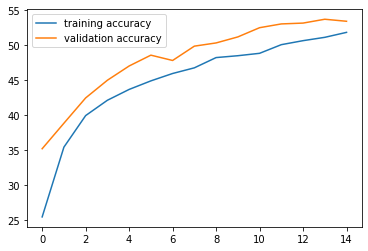

In [ ]:
plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()